## **Regression by AutoGluon**

Google Colaboratory環境でのDiamondsデータセットの回帰実行サンプル


【公式】Predicting Columns in a Table - Quick Start  
https://auto.gluon.ai/stable/tutorials/tabular_prediction/tabular-quickstart.html

【reference】AutoGluon Predictors  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit

【機械学習】AutoGluonの使い方・クイックスタートの解説(表形式データ) -  2021-06-17  
https://predora005.hatenablog.com/entry/2021/06/17/000000

#### **Google Colaboratoyの環境確認/設定**

In [1]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# AutoGluon
!pip install -U "folium==0.2.1"
!pip install -U "imgaug<0.2.7,>=0.2.5"
!pip install -U "mxnet_cu101<2.0.0"   # for GPU: CUDA 10.1 for coolge colaboratory
!pip install autogluon

Ubuntu 18.04.5 LTS \n \l

Linux 4f81f484f2b8 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal: 12.6867 GB
MemFree: 9.87895 GB
MemAvailable: 11.8897 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
/dev/sda1       154G   41G  114G  27% /opt/bin/.nvidia
0.0466861 hours (168.07sec)
Sun Aug 29 13:54:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+=========

### **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # pythonバージョン: 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
print(f'now: {datetime.now(JST):"%F %T)}') 

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

# metrix for Classificaqtion
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix     # 混同行列
from sklearn.metrics import classification_report
# metrix for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import autogluon as ag
from autogluon.tabular import TabularPredictor

import xgboost
import lightgbm
import catboost

#バージョン確認
print(sys.version)
print(f'Module\'s Version; ',
      f'\n sklearn: {sklearn.__version__}, numpy: {np.__version__}, pandas: {pd.__version__},',
      f'\n xgboost: {xgboost.__version__}, lightgbm: {lightgbm.__version__}, catboost: {catboost.__version__},',
      )

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: "2021-08-29 22:56:37)
3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
Module's Version;  
 sklearn: 0.24.2, numpy: 1.19.5, pandas: 1.1.5, 
 xgboost: 1.4.2, lightgbm: 3.2.1, catboost: 0.25.1,


#### **自作関数**

In [3]:
### Functions =================================================================
def xdescribe(df, dsp=True, ret=False):   # pandas.describeメソッドの拡張 

    print(f'## Shape:{df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Category Featurs: ')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return

### Functions =================================================================
# 変数の分布を確認
def target_dist(df, target_colname):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[target_colname])
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}')
    skewness    = skew(df[target_colname].dropna())
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}, 歪度 = {skewness:.2f}')

    # plot the distribution
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(target_colname+' distribution')
    sns.distplot(df[target_colname], fit=norm)

    ax = fig.add_subplot(1, 2, 2)
    stats.probplot(df[target_colname], plot=plt) #Q-Q plot
    plt.show()

### **データの取得・確認**

#### **seabornに含まれているdiamondsデータセットを使用**

各変数の属性の確認  
目的変数の分布を確認


## Shape:(53940, 10)


,dtype,NAs,n_unique,count,top,freq,...,std,min,25%,50%,75%,max
carat,float64,0,273,53940,NaN,NaN,...,0.474,0.2,0.4,0.7,1.04,5.01
cut,category,0,5,53940,Ideal,21551,...,NaN,NaN,NaN,NaN,NaN,NaN
color,category,0,7,53940,G,11292,...,NaN,NaN,NaN,NaN,NaN,NaN
clarity,category,0,8,53940,SI1,13065,...,NaN,NaN,NaN,NaN,NaN,NaN
depth,float64,0,184,53940,NaN,NaN,...,1.433,43,61,61.8,62.5,79
table,float64,0,127,53940,NaN,NaN,...,2.234,43,56,57,59,95
price,int64,0,11602,53940,NaN,NaN,...,3989,326,950,2401,5324,1.882e+04
x,float64,0,554,53940,NaN,NaN,...,1.122,0,4.71,5.7,6.54,10.74
y,float64,0,552,53940,NaN,NaN,...,1.142,0,4.72,5.71,6.54,58.9
z,float64,0,375,53940,NaN,NaN,...,0.7057,0,2.91,3.53,4.04,31.8


### Category Featurs: 
 cut: 	Index(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype='object')
 color: 	Index(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')
 clarity: 	Index(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], dtype='object')
Shapes: train:(43152, 10), test:(10788, 10)

## 目的変数の分布を確認

 平均 = 3933.70, 分散 = 3991.40

 平均 = 3933.70, 分散 = 3991.40, 歪度 = 1.62


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


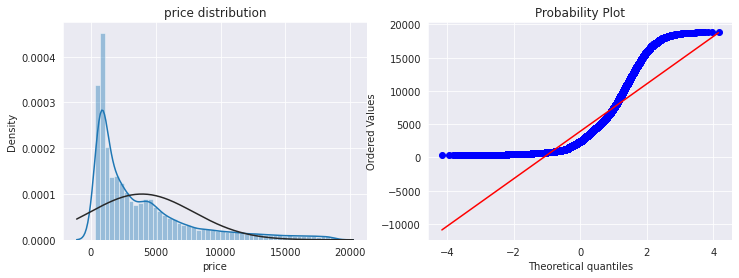

In [4]:
df = sns.load_dataset('diamonds') # データセットの読み込み
#   carat: weight of the diamond (0.2--5.01)
#     cut: cut qualitiy, Fair, Good, Very Good, Premium, Ideal
#   color: diamond colour, D (best) ~ J (worst)
# clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
#   depth: depth % :total depth percentage = z / mean(x, y) = 2 * z / (x + y)
#   table: table%: width of top of diamond relative to widest point
#   price: price in US dollars (\$326--\$18,823)
# x, y, z: length, width and depth in mm

xdescribe(df)                     # 各変数の属性を表示

target_colname = 'price'          # 目的変数を指定

# データセットの分割 (学習用と学習後の評価用)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0, shuffle=True)
print(f'Shapes: train:{df_train.shape}, test:{df_test.shape}')


print(f'\n## 目的変数の分布を確認') 
target_dist(df_train, target_colname)

### **データセット、学習に関する設定 (setup)**

### **TabularPredictor**  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor
```
class autogluon.tabular.TabularPredictor（
    label、
    problem_type = None、 # Default=None = Auto  'binary', 'multiclass', 'regression', 'quantile'
    eval_metric = None、  # Default=None = Auto 
        # Classification: ['accuracy', 'balanced_accuracy', 
        #     'f1', 'f1_macro', 'f1_micro', 'f1_weighted', 'roc_auc', 'roc_auc_ovo_macro7, 
        #     'average_precision', 'precision', 'precision_macro', 'precision_micro', ' Precision_weighted', 
        #     'recall', 'recall_macro', 'recall_micro', 'recall_weighted', 
        #     'log_loss', 'pac_score']                          
        # Regression:  ['root_mean_squared_error', 'mean_squared_error', 'mean_absolute_error', 
        #     'median_absolute_error', 'r2']             
    path = None、
    verbosity = 2、
    sample_weight = None、
    weight_evaluation = False、
    groups = None、** kwargs
）
```
### **fit**  
https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit

```
fit(
    train_data, 
    tuning_data = None, 
    time_limit = None, 
    presets = None,   # default = ['medium_quality_faster_train'] 
        # best_quality = {'auto_stack': True}
        # high_quality_fast_inference_only_refit   = {'auto_stack': True, 
        #     'refit_full': True, ''set_best_to_refit_full': True, '_ save_bag_folds': False}
        # good_quality_faster_inference_only_refit = {'auto_stack': True, 
        #     'refit_full': True, 'set_best_to_refit_full': True, '_ save_bag_folds': False, 
        #     'hyperparameters': 'light'}
        # medium_quality_faster_train = {'auto_stack': False}
        # optimize_for_deployment = {'keep_only_best': True, 'save_space': True}
        # ignore_text = {'_ feature_generator_kwargs'：{'enable_text_ngram_features'：False, 
        #     'enable_text_special_features': False, 'enable_raw_text_features': False}}
    hyperparameters= None, #  ['default', 'light', 'very_light', 'toy', 'multimodal']
    feature_metadata = 'infer', 
    **kwargs
)[source]¶
```

### **学習の準備**

In [5]:
# 全学習ケース同設定
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here

### **学習1, ほぼデフォルト**

In [6]:
time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(label=label, eval_metric=metric, path=save_path).fit(df_train)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    43152
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (18823, 327, 3933.6967, 3991.44248)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12644.47 MB
	Train Data (Original)  Memory Usage: 2.2 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generator

## 2021-08-29 22:56:41


		('float', [])    : 6 | ['carat', 'depth', 'table', 'x', 'y', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', []) : 3 | ['cut', 'color', 'clarity']
		('float', [])    : 6 | ['carat', 'depth', 'table', 'x', 'y', ...]
	0.2s = Fit runtime
	9 features in original data used to generate 9 features in processed data.
	Train Data (Processed) Memory Usage: 2.2 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.21s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric argument of fit()
Automatically generating train/validation split with holdout_frac=0.057934742306266225, Train Rows: 40652, Val Rows: 2500
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif ...
	0.8777	 = Validation score   (r2)
	0.06s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: KNeighborsDist ...
	0.8764	 = Validation score   (r2)
	0.06s	 = Training   runtime
	0.1s	 = 

[1000]	train_set's l2: 232666	train_set's r2: 0.985418	valid_set's l2: 285702	valid_set's r2: 0.981594


	0.9816	 = Validation score   (r2)
	5.58s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: LightGBM ...
	0.9816	 = Validation score   (r2)
	0.98s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	0.9811	 = Validation score   (r2)
	30.7s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: CatBoost ...
	0.9824	 = Validation score   (r2)
	16.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	0.9824	 = Validation score   (r2)
	11.74s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	0.9818	 = Validation score   (r2)
	47.33s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost ...
	0.9812	 = Validation score   (r2)
	1.42s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
	0.9831	 = Validation score   (r2)
	747.1s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: LightGBMLarge ...

## 2021-08-29 23:11:26, Elapse(Min):14.736


#### **学習の評価**

In [7]:
#predictor = TabularPredictor.load(save_path) # 保存したモデルを読み込む場合
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2     0.9838         0.6337  824.0837                  0.0031             0.3050            2       True         12
1        NeuralNetMXNet     0.9831         0.2496  747.1007                  0.2496           747.1007            1       True         10
2              CatBoost     0.9824         0.0086   16.1836                  0.0086            16.1836            1       True          6
3         ExtraTreesMSE     0.9824         0.3066   11.7427                  0.3066            11.7427            1       True          7
4       NeuralNetFastAI     0.9818         0.0489   47.3334                  0.0489            47.3334            1       True          8
5            LightGBMXT     0.9816         0.1418    5.5813                  0.1418             5.5813        

In [8]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.9825186972304852
Evaluations on test data:
{
    "r2": 0.9825186972304852,
    "root_mean_squared_error": -526.4105085253976,
    "mean_squared_error": -277108.0234859746,
    "mean_absolute_error": -255.14833947769748,
    "pearsonr": 0.9912312873866125,
    "median_absolute_error": -93.27362060546875
}


In [9]:
predictor.leaderboard(df_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE,0.9825,0.9824,1.3582,0.3066,11.7427,1.3582,0.3066,11.7427,1,True,7
1,WeightedEnsemble_L2,0.9825,0.9838,2.8392,0.6337,824.0837,0.0046,0.0031,0.3050,2,True,12
2,CatBoost,0.9817,0.9824,0.0442,0.0086,16.1836,0.0442,0.0086,16.1836,1,True,6
3,RandomForestMSE,0.9816,0.9811,1.3366,0.3054,30.7028,1.3366,0.3054,30.7028,1,True,5
4,LightGBMLarge,0.9810,0.9812,0.1858,0.0461,2.4208,0.1858,0.0461,2.4208,1,True,11
5,LightGBMXT,0.9809,0.9816,0.6696,0.1418,5.5813,0.6696,0.1418,5.5813,1,True,3
6,XGBoost,0.9805,0.9812,0.4783,0.0168,1.4182,0.4783,0.0168,1.4182,1,True,9
7,LightGBM,0.9804,0.9816,0.0645,0.0198,0.9837,0.0645,0.0198,0.9837,1,True,4
8,NeuralNetFastAI,0.9802,0.9818,0.1918,0.0489,47.3334,0.1918,0.0489,47.3334,1,True,8
9,NeuralNetMXNet,0.9799,0.9831,0.7621,0.2496,747.1007,0.7621,0.2496,747.1007,1,True,10


### **学習2**

good_quality_faster_inference_only_refit =   
{'auto_stack'：True, 'refit_full'：True, 'set_best_to_refit_full'：True, '_ save_bag_folds'：False, 'hyperparameters'： 'light'}

In [10]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here
time_limit = 2*3600          # Sec 処理制限時間
presets    = 'good_quality_faster_inference_only_refit'  # or 'high_quality_fast_inference_only_refit' 


time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(
    label=label, 
    eval_metric=metric, 
    path=save_path
).fit(
    df_train, 
    presets=presets, 
#    time_limit=time_limit,
)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['good_quality_faster_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    43152
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (18823, 327, 3933.6967, 3991.44248)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12199.59 MB
	Train Data (Original)  Memory Usage: 2.2 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Ge

## 2021-08-29 23:11:37


		('float', [])    : 6 | ['carat', 'depth', 'table', 'x', 'y', ...]
	0.1s = Fit runtime
	9 features in original data used to generate 9 features in processed data.
	Train Data (Processed) Memory Usage: 2.2 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.2s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric argument of fit()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 9 L1 models ...
Fitting model: LightGBMXT_BAG_L1 ...


[1000]	train_set's l2: 229882	train_set's r2: 0.985524	valid_set's l2: 328798	valid_set's r2: 0.979933
[2000]	train_set's l2: 197761	train_set's r2: 0.987547	valid_set's l2: 323970	valid_set's r2: 0.980227
[1000]	train_set's l2: 233132	train_set's r2: 0.985339	valid_set's l2: 268654	valid_set's r2: 0.983414
[2000]	train_set's l2: 199424	train_set's r2: 0.987459	valid_set's l2: 265450	valid_set's r2: 0.983612
[1000]	train_set's l2: 229715	train_set's r2: 0.985577	valid_set's l2: 322972	valid_set's r2: 0.979766
[2000]	train_set's l2: 197185	train_set's r2: 0.98762	valid_set's l2: 319153	valid_set's r2: 0.980005
[3000]	train_set's l2: 176727	train_set's r2: 0.988904	valid_set's l2: 319040	valid_set's r2: 0.980012
[1000]	train_set's l2: 230023	train_set's r2: 0.985535	valid_set's l2: 281851	valid_set's r2: 0.982598
[2000]	train_set's l2: 197138	train_set's r2: 0.987603	valid_set's l2: 279651	valid_set's r2: 0.982734
[1000]	train_set's l2: 235945	train_set's r2: 0.985204	valid_set's l2: 253

	0.9819	 = Validation score   (r2)
	163.08s	 = Training   runtime
	8.75s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.982	 = Validation score   (r2)
	32.39s	 = Training   runtime
	1.16s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.9818	 = Validation score   (r2)
	25.56s	 = Training   runtime
	1.39s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9826	 = Validation score   (r2)
	239.6s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9824	 = Validation score   (r2)
	7.33s	 = Training   runtime
	1.35s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.9799	 = Validation score   (r2)
	382.38s	 = Training   runtime
	0.65s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.9814	 = Validation score   (r2)
	21.98s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ...
	0.9808	 = Validation score   (r2)
	4547.55s	 = Training   runtime
	3.74s

[1000]	train_set's l2: 51870.5	train_set's r2: 0.996747	valid_set's l2: 321794	valid_set's r2: 0.979621


	0.9818	 = Validation score   (r2)
	48.27s	 = Training   runtime
	2.3s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.9836	 = Validation score   (r2)
	0.89s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 9 L2 models ...
Fitting model: LightGBMXT_BAG_L2 ...
	0.983	 = Validation score   (r2)
	15.79s	 = Training   runtime
	0.45s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	0.9834	 = Validation score   (r2)
	12.65s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	0.9833	 = Validation score   (r2)
	92.37s	 = Training   runtime
	1.38s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	0.9833	 = Validation score   (r2)
	67.94s	 = Training   runtime
	0.09s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L2 ...
	0.9836	 = Validation score   (r2)
	13.15s	 = Training   runtime
	1.37s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L2 ...
No improvement since epoch 9: early stopping
	0.9836

[1000]	train_set's l2: 230557	train_set's r2: 0.985528
[2000]	train_set's l2: 199954	train_set's r2: 0.987449


	12.48s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM_BAG_L1_FULL ...
	2.55s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: RandomForestMSE_BAG_L1_FULL ...
	0.9818	 = Validation score   (r2)
	25.35s	 = Training   runtime
	1.39s	 = Validation runtime
Fitting 1 L1 models ...
Fitting model: CatBoost_BAG_L1_FULL ...
	25.08s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: ExtraTreesMSE_BAG_L1_FULL ...
	0.9824	 = Validation score   (r2)
	7.44s	 = Training   runtime
	1.27s	 = Validation runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetFastAI_BAG_L1_FULL ...
	Stopping at the best epoch learned earlier - 24.
	33.04s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost_BAG_L1_FULL ...
	2.2s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetMXNet_BAG_L1_FULL ...
	87.18s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBMLarge_BAG_L1_FULL ...
	3.88s	 = Training   runtime
Fitting model: W

## 2021-08-30 01:45:38, Elapse(Min):154.025


In [11]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3     0.9839        27.7801  8645.7806                  0.0011             0.8657            3      False         20
1        NeuralNetFastAI_BAG_L2     0.9836        20.5795  5852.7006                  0.7108           384.5587            2      False         16
2           WeightedEnsemble_L2     0.9836        18.7127  5436.6379                  0.0011             0.8882            2      False         10
3          ExtraTreesMSE_BAG_L2     0.9836        21.2361  5481.2962                  1.3674            13.1542            2      False         15
4     ExtraTreesMSE_BAG_L2_FULL     0.9836            NaN   212.3594                  1.3642            13.1531            2       True         35
5               LightGBM_BAG_L2     0.9834        20.095

In [12]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.9830622362144813
Evaluations on test data:
{
    "r2": 0.9830622362144813,
    "root_mean_squared_error": -518.1621534399884,
    "mean_squared_error": -268492.0172575722,
    "mean_absolute_error": -253.95725458730004,
    "pearsonr": 0.9914951879397527,
    "median_absolute_error": -91.283447265625
}


### **学習3**

high_quality_fast_inference_only_refit   =  
{'auto_stack': True, 'refit_full': True, ''set_best_to_refit_full': True, '_ save_bag_folds': False}

In [13]:
import autogluon as ag
from autogluon.tabular import TabularPredictor

label      = target_colname  # 目的関数 ('price')
save_path  = 'agModels'      # 学習モデルの保管場所
metric     = 'r2'            # specify your evaluation metric here
time_limit = 5*3600          # Sec 処理制限時間
presets    = 'high_quality_fast_inference_only_refit' 

time_start = datetime.now(JST)
print(f'## {time_start:%F %T}')

predictor = TabularPredictor(
    label=label, 
    eval_metric=metric, 
    path=save_path
).fit(
    df_train, 
    presets=presets, 
#    time_limit=time_limit,
)

elapse = (datetime.now(JST)-time_start).total_seconds()
print(f'## {datetime.now(JST):%F %T}, Elapse(Min):{elapse/60:.3f}')

Presets specified: ['high_quality_fast_inference_only_refit']
Beginning AutoGluon training ...
AutoGluon will save models to "agModels/"
AutoGluon Version:  0.3.0
Train Data Rows:    43152
Train Data Columns: 9
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (18823, 327, 3933.6967, 3991.44248)
	If 'regression' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12040.45 MB
	Train Data (Original)  Memory Usage: 2.2 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Gene

## 2021-08-30 01:45:47


	Types of features in original data (raw dtype, special dtypes):
		('category', []) : 3 | ['cut', 'color', 'clarity']
		('float', [])    : 6 | ['carat', 'depth', 'table', 'x', 'y', ...]
	Types of features in processed data (raw dtype, special dtypes):
		('category', []) : 3 | ['cut', 'color', 'clarity']
		('float', [])    : 6 | ['carat', 'depth', 'table', 'x', 'y', ...]
	0.2s = Fit runtime
	9 features in original data used to generate 9 features in processed data.
	Train Data (Processed) Memory Usage: 2.2 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.22s ...
AutoGluon will gauge predictive performance using evaluation metric: 'r2'
	To change this, specify the eval_metric argument of fit()
AutoGluon will fit 2 stack levels (L1 to L2) ...
Fitting 11 L1 models ...
Fitting model: KNeighborsUnif_BAG_L1 ...
	0.866	 = Validation score   (r2)
	0.06s	 = Training   runtime
	0.41s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L1 ...
	0.8642	 = Vali

[1000]	train_set's l2: 229882	train_set's r2: 0.985524	valid_set's l2: 328798	valid_set's r2: 0.979933
[2000]	train_set's l2: 197761	train_set's r2: 0.987547	valid_set's l2: 323970	valid_set's r2: 0.980227
[1000]	train_set's l2: 233132	train_set's r2: 0.985339	valid_set's l2: 268654	valid_set's r2: 0.983414
[2000]	train_set's l2: 199424	train_set's r2: 0.987459	valid_set's l2: 265450	valid_set's r2: 0.983612
[1000]	train_set's l2: 229715	train_set's r2: 0.985577	valid_set's l2: 322972	valid_set's r2: 0.979766
[2000]	train_set's l2: 197185	train_set's r2: 0.98762	valid_set's l2: 319153	valid_set's r2: 0.980005
[3000]	train_set's l2: 176727	train_set's r2: 0.988904	valid_set's l2: 319040	valid_set's r2: 0.980012
[1000]	train_set's l2: 230023	train_set's r2: 0.985535	valid_set's l2: 281851	valid_set's r2: 0.982598
[2000]	train_set's l2: 197138	train_set's r2: 0.987603	valid_set's l2: 279651	valid_set's r2: 0.982734
[1000]	train_set's l2: 235945	train_set's r2: 0.985204	valid_set's l2: 253

	0.9819	 = Validation score   (r2)
	162.34s	 = Training   runtime
	8.93s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ...
	0.982	 = Validation score   (r2)
	32.33s	 = Training   runtime
	1.3s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ...
	0.9816	 = Validation score   (r2)
	32.16s	 = Training   runtime
	1.88s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ...
	0.9826	 = Validation score   (r2)
	240.03s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ...
	0.9824	 = Validation score   (r2)
	12.64s	 = Training   runtime
	1.93s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ...
	0.9795	 = Validation score   (r2)
	382.54s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: XGBoost_BAG_L1 ...
	0.9814	 = Validation score   (r2)
	22.09s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: NeuralNetMXNet_BAG_L1 ...
	0.9813	 = Validation score   (r2)
	4976.75s	 = Training   runtime
	3.63

[1000]	train_set's l2: 51870.5	train_set's r2: 0.996747	valid_set's l2: 321794	valid_set's r2: 0.979621


	0.9818	 = Validation score   (r2)
	48.35s	 = Training   runtime
	2.32s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.9836	 = Validation score   (r2)
	1.02s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting 11 L2 models ...
Fitting model: KNeighborsUnif_BAG_L2 ...
	0.9812	 = Validation score   (r2)
	0.03s	 = Training   runtime
	82.48s	 = Validation runtime
Fitting model: KNeighborsDist_BAG_L2 ...
	0.9812	 = Validation score   (r2)
	0.03s	 = Training   runtime
	82.13s	 = Validation runtime
Fitting model: LightGBMXT_BAG_L2 ...
	0.983	 = Validation score   (r2)
	19.37s	 = Training   runtime
	0.58s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ...
	0.9834	 = Validation score   (r2)
	12.24s	 = Training   runtime
	0.2s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ...
	0.9831	 = Validation score   (r2)
	144.59s	 = Training   runtime
	2.13s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ...
	0.9835	 = Validation score   (r2)
	77.82s	 = Trai

[1000]	train_set's l2: 230557	train_set's r2: 0.985528
[2000]	train_set's l2: 199954	train_set's r2: 0.987449


	12.54s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBM_BAG_L1_FULL ...
	2.49s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: RandomForestMSE_BAG_L1_FULL ...
	0.9816	 = Validation score   (r2)
	32.18s	 = Training   runtime
	1.93s	 = Validation runtime
Fitting 1 L1 models ...
Fitting model: CatBoost_BAG_L1_FULL ...
	24.82s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: ExtraTreesMSE_BAG_L1_FULL ...
	0.9824	 = Validation score   (r2)
	12.64s	 = Training   runtime
	1.93s	 = Validation runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetFastAI_BAG_L1_FULL ...
	Stopping at the best epoch learned earlier - 25.
	34.63s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: XGBoost_BAG_L1_FULL ...
	2.27s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: NeuralNetMXNet_BAG_L1_FULL ...
	87.66s	 = Training   runtime
Fitting 1 L1 models ...
Fitting model: LightGBMLarge_BAG_L1_FULL ...
	3.94s	 = Training   runtime
Fitting model:

## 2021-08-30 04:29:30, Elapse(Min):163.711


In [14]:
results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                          model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3     0.9839       113.7296  8846.5273                  0.0011             1.0097            3      False         24
1        NeuralNetFastAI_BAG_L2     0.9837        22.7200  6295.8200                  0.7164           386.4788            2      False         20
2           WeightedEnsemble_L2     0.9836        19.8896  5877.9122                  0.0024             1.0240            2      False         12
3          ExtraTreesMSE_BAG_L2     0.9835        24.1137  5936.6405                  2.1100            27.2993            2      False         19
4     ExtraTreesMSE_BAG_L2_FULL     0.9835            NaN   240.6562                  2.1053            27.3776            2       True         43
5               CatBoost_BAG_L2     0.9835        22.096

In [15]:
y_pred = predictor.predict(df_test.drop(columns=[label]))
perf = predictor.evaluate_predictions(y_true=df_test[label], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: r2 on test data: 0.9835291739892211
Evaluations on test data:
{
    "r2": 0.9835291739892211,
    "root_mean_squared_error": -510.9699295577016,
    "mean_squared_error": -261090.26891220766,
    "mean_absolute_error": -251.36818620386856,
    "pearsonr": 0.9917437440068148,
    "median_absolute_error": -90.57504272460938
}
